In today's rapidly evolving ride-hailing industry, dynamic pricing plays a critical role in balancing supply and demand while ensuring profitability.

My project on Optiprice Prognosticator:Pricing Prediction aims to predict ride prices based on a variety of influential factors.

These factors include ride-specific details such as:

*1.Number of riders

*2.Number of drivers

*3.Location category

*4.Customer loyalty status

*5.Number of past rides

*6.Time of Booking

*7.Average rating

*8.Vehicle type

*9.Expected ride duration

10.Historical cost of ride

By analyzing historical ride data and external conditions, this project seeks to develop an accurate predictive model that can help ride-hailing platforms optimize pricing strategies, improve customer satisfaction, and enhance operational efficiency. The ultimate goal is to offer a solution that aligns with market dynamics and maximizes both rider affordability and driver earnings.

# **LIBRARIES**

In [180]:
# Ignore Warnings
import warnings


import dill

# Data Manipulation
import pandas as pd
import numpy as np

# Imputation - RandomForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Transformation
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Pipeline
from sklearn.pipeline import Pipeline

# Metrics
import math
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import r2_score

# Regression Algorithms
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings('ignore')  # Disabling warning outputs

In [181]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/dynamic-pricing-dataset/dynamic_pricing.csv


# **LOADING DATA**

In [182]:
data = pd.read_csv("/kaggle/input/dynamic-pricing-dataset/dynamic_pricing.csv")
print(data)

     Number_of_Riders  Number_of_Drivers Location_Category  \
0                  90                 45             Urban   
1                  58                 39          Suburban   
2                  42                 31             Rural   
3                  89                 28             Rural   
4                  78                 22             Rural   
..                ...                ...               ...   
995                33                 23             Urban   
996                84                 29             Urban   
997                44                  6          Suburban   
998                53                 27          Suburban   
999                78                 63             Rural   

    Customer_Loyalty_Status  Number_of_Past_Rides  Average_Ratings  \
0                    Silver                    13             4.47   
1                    Silver                    72             4.06   
2                    Silver                  

In [183]:
data.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


# **DATA PREPROCESSING**

In [184]:
#shape
data.shape

(1000, 10)

In [185]:
#info()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   Historical_Cost_of_Ride  1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.2+ KB


In [186]:
data.columns

Index(['Number_of_Riders', 'Number_of_Drivers', 'Location_Category',
       'Customer_Loyalty_Status', 'Number_of_Past_Rides', 'Average_Ratings',
       'Time_of_Booking', 'Vehicle_Type', 'Expected_Ride_Duration',
       'Historical_Cost_of_Ride'],
      dtype='object')

# **EXPLORATORY DATA ANALYSIS**

In [187]:
#creating a data dictionary

def get_data_dictionary(data):
    data_dict = pd.DataFrame(columns = ['Column','Count','Unique Values','Range',
                                       'Null values','Possible values'])
    for col in data.columns:
        count = data[col].shape[0]
        unique_values = data[col].nunique()
        if unique_values>1:
            range = f"{data[col].min()} - {data[col].max()}"
        else:
            range = np.nan
        nulls = data[col].isna().sum()
        values = list(data[col].sample(frac = 0.25,replace=False,random_state=42))
        values = list(set(values))[:5]
        data_dict.loc[len(data_dict)] = [col,count,unique_values,range,nulls,values]
    return data_dict     

In [188]:
data_dict = get_data_dictionary(data)
data_dict

,Column,Count,Unique Values,Range,Null values,Possible values
0,Number_of_Riders,1000,81,20 - 100,0,"[21, 22, 23, 24, 25]"
1,Number_of_Drivers,1000,79,5 - 89,0,"[5, 6, 7, 8, 9]"
2,Location_Category,1000,3,Rural - Urban,0,"[Suburban, Rural, Urban]"
3,Customer_Loyalty_Status,1000,3,Gold - Silver,0,"[Silver, Regular, Gold]"
4,Number_of_Past_Rides,1000,101,0 - 100,0,"[0, 1, 2, 3, 4]"
5,Average_Ratings,1000,151,3.5 - 5.0,0,"[3.53, 4.78, 3.57, 4.98, 4.29]"
6,Time_of_Booking,1000,4,Afternoon - Night,0,"[Morning, Night, Afternoon, Evening]"
7,Vehicle_Type,1000,2,Economy - Premium,0,"[Economy, Premium]"
8,Expected_Ride_Duration,1000,171,10 - 180,0,"[11, 12, 14, 16, 17]"
9,Historical_Cost_of_Ride,1000,1000,25.993449448411635 - 836.1164185613576,0,"[517.9444619823878, 518.9547629602604, 510.626..."


In [189]:
# Provides summary statistics for numerical columns in the dataset.
data.describe()

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,60.372000,27.076000,50.031000,4.257220,99.58800,372.502623
std,23.701506,19.068346,29.313774,0.435781,49.16545,187.158756
min,20.000000,5.000000,0.000000,3.500000,10.00000,25.993449
25%,40.000000,11.000000,25.000000,3.870000,59.75000,221.365202
50%,60.000000,22.000000,51.000000,4.270000,102.00000,362.019426
75%,81.000000,38.000000,75.000000,4.632500,143.00000,510.497504
max,100.000000,89.000000,100.000000,5.000000,180.00000,836.116419


In [190]:
#correlation

data[['Number_of_Riders', 'Number_of_Drivers' , 'Number_of_Past_Rides','Average_Ratings','Expected_Ride_Duration','Historical_Cost_of_Ride']].corr()

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride
Number_of_Riders,1.000000,0.627016,0.029265,0.008572,-0.015856,0.005826
Number_of_Drivers,0.627016,1.000000,0.039660,0.041204,-0.024418,0.017082
Number_of_Past_Rides,0.029265,0.039660,1.000000,-0.064734,0.030679,0.035859
Average_Ratings,0.008572,0.041204,-0.064734,1.000000,-0.016968,-0.001063
Expected_Ride_Duration,-0.015856,-0.024418,0.030679,-0.016968,1.000000,0.927547
Historical_Cost_of_Ride,0.005826,0.017082,0.035859,-0.001063,0.927547,1.000000


<Axes: >

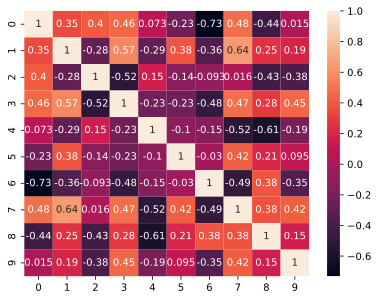

In [191]:
#corelation plot

sns.heatmap(corelation, xticklabels=corelation.columns, yticklabels=corelation.columns,annot=True)

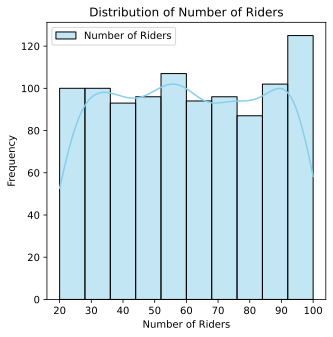

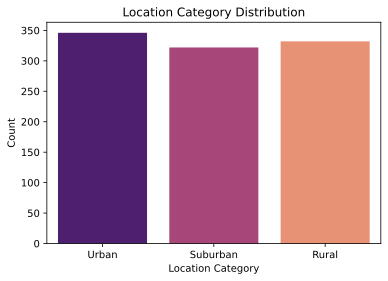

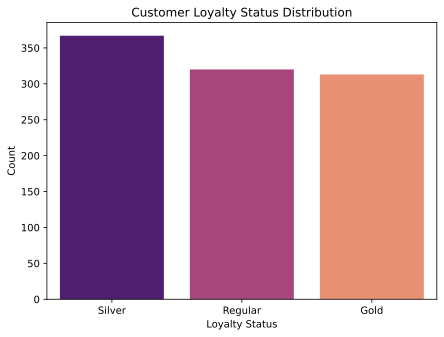

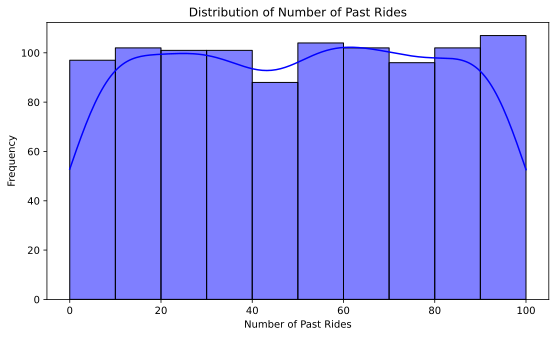

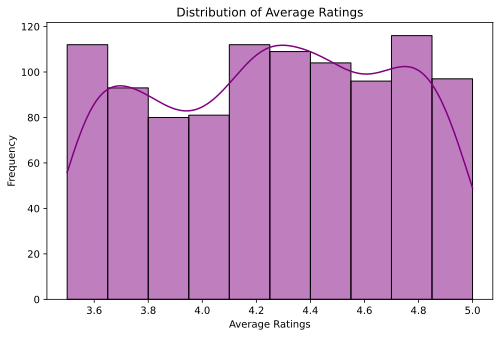

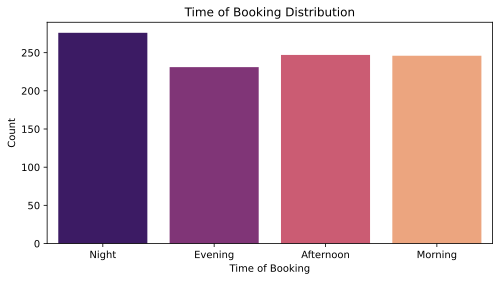

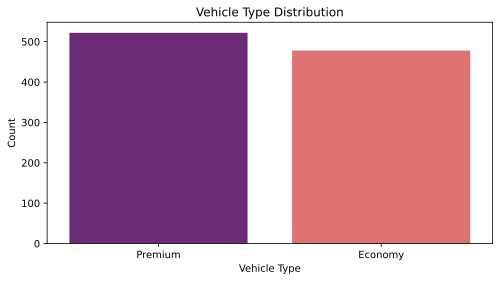

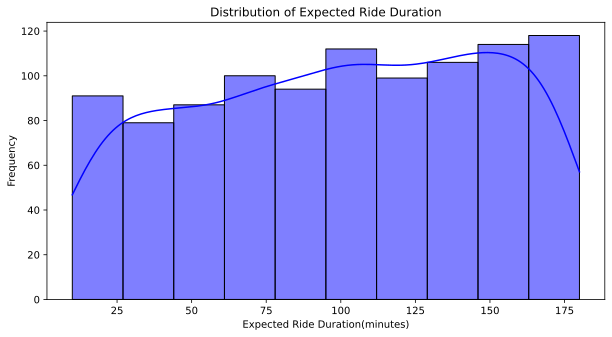

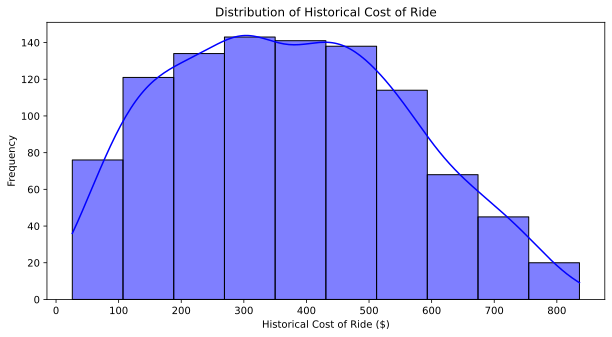

In [192]:
# Visualizing the distribution of a single variable to understand its central tendency, spread, and shape.

plt.figure(figsize=(5, 5))
sns.histplot(data['Number_of_Riders'], bins=10, kde=True, color='skyblue', label='Number of Riders')
plt.title('Distribution of Number of Riders')
plt.xlabel('Number of Riders')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x='Location_Category', data=data, palette='magma')
plt.title('Location Category Distribution')
plt.xlabel('Location Category')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(7, 5))
sns.countplot(x='Customer_Loyalty_Status', data=data, palette='magma')
plt.title('Customer Loyalty Status Distribution')
plt.xlabel('Loyalty Status')
plt.ylabel('Count')
plt.show()


plt.figure(figsize=(9, 5))
sns.histplot(data['Number_of_Past_Rides'], bins=10, kde=True, color='blue')
plt.title('Distribution of Number of Past Rides')
plt.xlabel('Number of Past Rides')
plt.ylabel('Frequency')
plt.show()


plt.figure(figsize=(8, 5))
sns.histplot(data['Average_Ratings'], bins=10, kde=True, color='purple')
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Ratings')
plt.ylabel('Frequency')
plt.show()


plt.figure(figsize=(8, 4))
sns.countplot(x='Time_of_Booking', data=data, palette='magma')
plt.title('Time of Booking Distribution')
plt.xlabel('Time of Booking')
plt.ylabel('Count')
plt.show()


plt.figure(figsize=(8, 4))
sns.countplot(x='Vehicle_Type', data=data, palette='magma')
plt.title('Vehicle Type Distribution')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.show()


plt.figure(figsize=(10, 5))
sns.histplot(data['Expected_Ride_Duration'], bins=10, kde=True, color='blue')
plt.title('Distribution of Expected Ride Duration')
plt.xlabel('Expected Ride Duration(minutes)')
plt.ylabel('Frequency')
plt.show()


plt.figure(figsize=(10, 5))
sns.histplot(data['Historical_Cost_of_Ride'], bins=10, kde=True, color='blue')
plt.title('Distribution of Historical Cost of Ride')
plt.xlabel('Historical Cost of Ride ($)')
plt.ylabel('Frequency')
plt.show()


In [193]:
import plotly.graph_objects as go
import plotly.express as px

import plotly.io as pio
from ipywidgets import interact
pio.renderers.default = "iframe"

In [194]:
# Understanding demand at different times of booking

fig = px.bar(data, x='Time_of_Booking', y='Number_of_Riders', title='Ride Demand Over Time')
fig.show()


In [195]:
#Investigating price patterns across different times or locations 


fig = px.bar(data, x='Time_of_Booking', y='Historical_Cost_of_Ride', title='Fare Distribution by Hour of Day')
fig.show()


In [196]:
#analyzing ride usage patterns by loyalty status helps identify valuable customers.

fig = px.pie(data, names='Customer_Loyalty_Status', values='Number_of_Riders',title='Ride by Loyalty Status')
fig.show()


In [197]:
#Determine if longer rides are being priced appropriately or if certain distances have a lower-than-expected fare.

fig = px.line(data, x="Expected_Ride_Duration", y="Historical_Cost_of_Ride", title="Average Fare by Distance(minute)")
fig.show()


In [198]:
fig = px.bar(data, x="Location_Category", y="Expected_Ride_Duration", title="Ride Duration vs Distance")
fig.show()


In [199]:
fig = px.pie(data, names="Location_Category", values="Historical_Cost_of_Ride", title="fare by location")
fig.show()


In [200]:
fig = px.bar(data, x='Location_Category',y='Number_of_Riders', title='Ride by location')
fig.show()


In [201]:
fig = px.bar(data, x='Time_of_Booking', y='Expected_Ride_Duration', title='Ride Duration by Time of Day')
fig.show()
